In [47]:
import numpy as np 
import pyxu.experimental.xray as pxr
import pyxu.opt.stop as pxst
import matplotlib.pyplot as plt
import numpy as cp
import xdesign as xd

In [48]:
def set_operators_parallel_beam(N_side, N_angle, N_offset, pitch_op, arg_shape):
    # Let's build the necessary components to instantiate the operator . ========================
    angles = np.linspace(0, np.pi, N_angle, endpoint=False)

    n = np.stack([np.cos(angles), np.sin(angles)], axis=1)
    pitch = 1.
    t        = n[:, [1, 0]] * np.r_[-1, 1]  # <n, t> = 0
    t_max    = pitch * (N_side-1) / 2 * 1.  # 10% over ball radius
    t_offset = np.linspace(-t_max, t_max, N_offset, endpoint=True)

    n_spec  = np.broadcast_to(n.reshape(N_angle, 1, 2), (N_angle, N_offset, 2))  # (N_angle, N_offset, 2)
    t_spec  = t.reshape(N_angle, 1, 2) * t_offset.reshape(N_offset, 1)  # (N_angle, N_offset, 2)
    t_spec += pitch * N_side / 2  # Move anchor point to the center of volume.

    origin  = (0., 0.)
    pitch   = (1.,1.)

    t_spec  = cp.array(t_spec)
    n_spec  = cp.array(n_spec)

    op_pixels = pxr.XRayTransform.init(
        arg_shape=arg_shape,
        t_spec=t_spec.reshape(-1,2), 
        n_spec=n_spec.reshape(-1,2),
        origin=origin,
        pitch=pitch_op,
    )

    return op_pixels



In [49]:
def create_phantom(N_side):
    seed = 0
    # Generate phantom with xdesign
    np.random.seed(seed)
    p1 = xd.Foam(size_range=[0.1, 0.01], gap=0.025, porosity=0.5)
    phantom = xd.discrete_phantom(p1, N_side-40) * 10
    phantom = np.abs(np.pad(phantom, 40))

    return cp.array(phantom)

/home/haouchat/miniconda3/envs/tomo/lib/python3.11/site-packages/xdesign/phantom/phantom.py:375: RuntimeWarning: Reached termination criteria of 500 attempts before adding all of the circles.
  warnings.warn((


(341, 341)


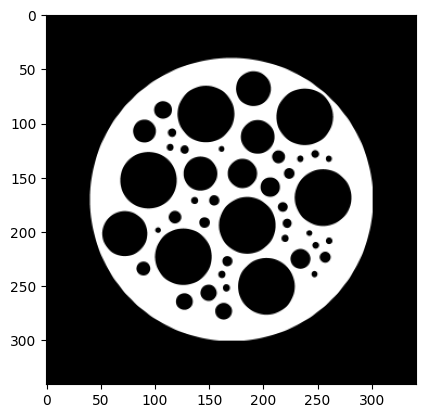

In [50]:
N_side = 301 #5000

phantom = create_phantom(N_side)

arg_shape = phantom.shape
print(arg_shape)
plt.figure()
plt.imshow(phantom, cmap='gray')
plt.show()

### set the operator

In [51]:
pitch_op = (1.,1.) 
N_angle  = 300
N_offset = 300
op_pixels = set_operators_parallel_beam(N_side, N_angle, N_offset, pitch_op, arg_shape)

### compute the forward model to the phantom image

/home/haouchat/miniconda3/envs/tomo/lib/python3.11/site-packages/pyxu/experimental/xray/_rt.py:208: PrecisionWarning: Only Width.SINGLE-precision inputs are supported: casting.
  warnings.warn(msg, pxw.PrecisionWarning)


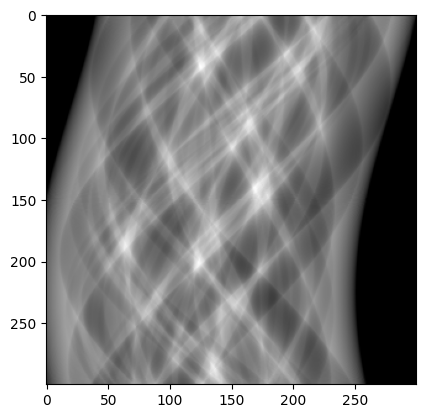

In [52]:
fwd_pixels = op_pixels.apply(phantom.reshape(-1))
fwd_pixels = fwd_pixels.reshape(N_angle, N_offset)

plt.figure()
plt.imshow(fwd_pixels, cmap='gray')
plt.show()

### compute the adjoint of the operator, namely the backprojection, to the data

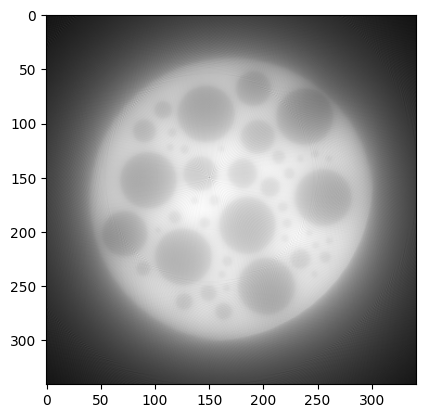

In [53]:
backprojection = op_pixels.adjoint(fwd_pixels.reshape(-1))
backprojection = backprojection.reshape(arg_shape)

plt.figure()
plt.imshow(backprojection, cmap='gray')
plt.show()

(341, 341)
(341, 341)
(341, 341)
(341, 341)


Text(0.5, 1.0, 'Convolved Image 3')

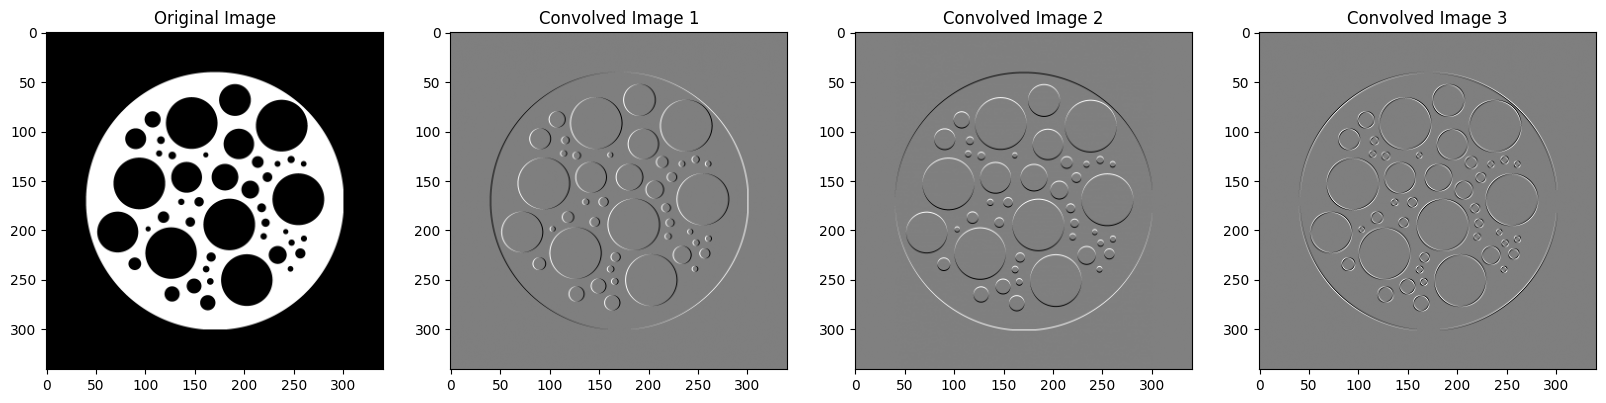

In [67]:
import torch
from scipy.signal import fftconvolve

print(phantom.shape)

#convolution kernel 1 
kernel = np.array([
[-1/2, 1/2],
])
conv_image_1 = fftconvolve(phantom, kernel, mode='same')
print(conv_image_1.shape)

#convolution kernel 2 
kernel = np.array([
[-1/2],
[1/2],
])
conv_image_2 = fftconvolve(phantom, kernel, mode='same')
print(conv_image_2.shape)  

#convolution kernel 3 
kernel = np.array([
[-1/4, 1/4],
[1/4, -1/4]
])
conv_image_3 = fftconvolve(phantom, kernel, mode='same')
print(conv_image_3.shape)

plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.imshow(phantom, cmap='gray')
plt.title('Original Image')
plt.subplot(1, 4, 2)
plt.imshow(conv_image_1, cmap='gray')
plt.title('Convolved Image 1')
plt.subplot(1, 4, 3)
plt.imshow(conv_image_2, cmap='gray')
plt.title('Convolved Image 2')
plt.subplot(1, 4, 4)
plt.imshow(conv_image_3, cmap='gray')
plt.title('Convolved Image 3')


